In [1]:
import os
import pandas as pd
import wfdb
import ecg_plot
import ast
from tqdm import tqdm
from multiprocessing import Pool, set_start_method

In [2]:
record = wfdb.rdrecord('data/ptb-xl/records500/00000/00005_hr')
ecg_data = record.p_signal.T
lead_names = record.sig_name

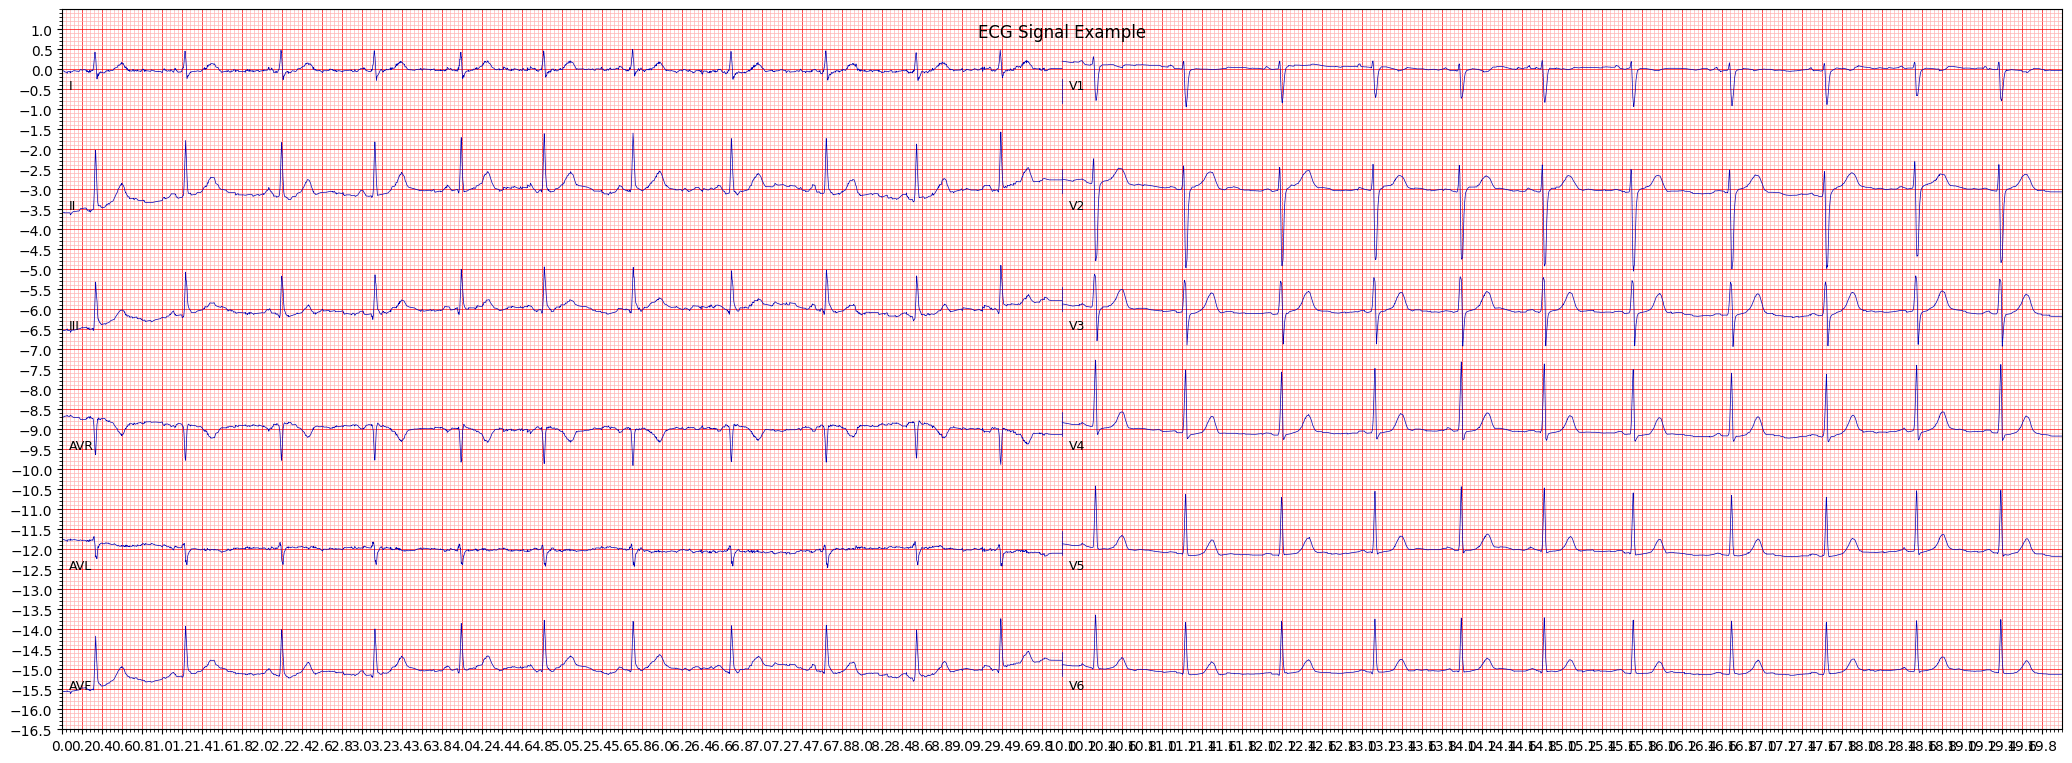

In [3]:
ecg_plot.plot(ecg_data[:, :5000], sample_rate = record.fs, lead_index = lead_names, title= 'ECG Signal Example')
ecg_plot.show()

In [4]:
CSV_PATH = 'data/ptb-xl/ptbxl_database.csv'
RECORDS_PATH = 'data/ptb-xl/'
OUTPUT_DIR = 'data/ptb-xl_images_multiprocessed'
NUM_WORKERS = 6

In [5]:
def get_main_label(scp_dict):
    if not scp_dict:
        return 'Unknown'
    return sorted(scp_dict.keys())[0]

In [6]:
import sys

def process_ecg(row_dict):
    print(f"Start processing {row_dict['ecg_id']}...")
    sys.stdout.flush()
    import ecg_plot # Potentially problematic import for multiprocessing

    ecg_id = row_dict['ecg_id']
    filename_hr = row_dict['filename_hr']
    scp_label = get_main_label(row_dict['scp_codes'])

    print(f'Ecg_id: {ecg_id}\nFilename_hr: {filename_hr}\nscp_label: {scp_label}')
    sys.stdout.flush()

    try:
        record_path = os.path.join(RECORDS_PATH, *filename_hr.split('/')[1:])
        print(f"Attempting to read record: {record_path}")
        sys.stdout.flush()
        record = wfdb.rdrecord(record_path)
        print(f"Record read successfully: {ecg_id}")
        sys.stdout.flush()

        ecg_data = record.p_signal.T
        lead_names = record.sig_name

        print(f"Plotting ECG for {ecg_id}...")
        sys.stdout.flush()
        ecg_plot.plot(ecg_data[:, :5000], sample_rate = record.fs, lead_index = lead_names)
        print(f"Plotting done for {ecg_id}.")
        sys.stdout.flush()

        safe_label = scp_label.replace("/", "-").replace(" ", "_")
        save_filename = f"{ecg_id}_{safe_label}"
        save_path = os.path.join(OUTPUT_DIR, save_filename)

        print(f"Saving PNG for {ecg_id} to {save_path}...")
        sys.stdout.flush()
        ecg_plot.save_as_png(save_path)
        print(f"PNG saved for {ecg_id}.")
        sys.stdout.flush()

        return True
    except Exception as e:
        print(f"[Error] {filename_hr}: {e}")
        sys.stdout.flush()
        return False

In [ ]:
if __name__ == "__main__":
    try:
        set_start_method("spawn", force = True)
    except RuntimeError:
        pass

    print(f"Using {NUM_WORKERS} CPU cores...")

    df = pd.read_csv(CSV_PATH)
    df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)

    rows = df.to_dict(orient='records')
    
    os.makedirs(OUTPUT_DIR, exist_ok = True)

    print("Starting parellel processing...")
    with Pool(processes = 6) as pool:
        results = list(tqdm(pool.imap(process_ecg, rows), total = len(rows)))
    
    success_count = sum(results)
    print(f"\n Finished: {success_count}/{len(rows)} ECGs processes successfully.")

Using 6 CPU cores...
Starting parellel processing...


  0%|          | 0/21799 [00:00<?, ?it/s]